# Creating Plots and Performance Statistics

**Purpose:** We are looking to plot the data from the NOAA WW3 forecast for a number of locations where monitoring is taking place. The intention is to provide a tool to compare the forecast to the monitored data statistcally and visually.

**Creator:** Leo Peach

**Datasets:** QLD Government wave monitoring sites and NOAA WW3 Global wave model

In [3]:
import datetime
import numpy as np
import pandas as pd
import numpy as np
#plotting libraries
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, Span
from bokeh.models.tools import HoverTool
#fetch data libraries
import fetch_online_des_waves
import fetch_multigrid


Set up a function to extract the data from the model grid

In [4]:
def get_data():
    """A function that retrieced the data for the wave buoy locations from the forecast model"""
    
    wb_data = fetch_online_des_waves.get_waves()
    ww3_data = fetch_multigrid.main()
    # sites with available data
    ww3_data[0].dropna(inplace = True)
    sites = ww3_data[0].site.unique()
    print(sites)
    site_data = []
    for i in sites:
        mdata = wb_data.loc[wb_data['Site'] == i]
        data = [mdata]
        for run in ww3_data:
            run.dropna(inplace = True)
            fdata = run.loc[run['site'] == i]
            data.append(fdata)
        site_data.append(data)
    return site_data

Setting up plotting functions so that data can be visually inspected

In [ ]:
def plot_bokeh(site_data):
    """generate a plot object based on a list of forecasts and actuals for a location"""
    print(site_data[0].iloc[0,1])
    sitename = site_data[0].iloc[0,1]
    
    p = figure(x_axis_type="datetime", plot_height = 500, plot_width = 1000, title=sitename )
    p.sizing_mode = 'scale_width'
    
    for fore in site_data[1:-1]:
        p.line(fore.index, y = fore['htsgwsfc'], line_alpha=0.25, line_dash='dashed')

    plotf =p.line(x = site_data[-1].index,y = site_data[-1]['htsgwsfc'], color = 'blue',legend='Recent Forecast')
    p.add_tools(HoverTool(renderers=[plotf], tooltips=[("Hm0","@y")],mode='vline'))
    plota = p.line(site_data[0].index, pd.to_numeric(site_data[0]['Hsig']), color = 'green',legend='Actual')
    p.add_tools(HoverTool(renderers=[plota], tooltips=[("Hsig","@y")],mode='vline'))
    now_line = Span(location=datetime.datetime.now(),dimension='height', line_color='red',line_dash='dashed', line_width=2)
    p.add_layout(now_line)

    
    p.yaxis.axis_label = "Signifcant Wave Height (m)"
    
    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    from bokeh.resources import CDN
    from bokeh.embed import file_html, components
    #fig = file_html(p, CDN)
    script, div = components(p)
    return (script, div)

In [ ]:
def plot_bokeh_per(site_data):
    """generate a plot object based on a list of forecasts and actuals for a location"""
    print(site_data[0].iloc[0,1])
    sitename = site_data[0].iloc[0,1]
    
    p = figure(x_axis_type="datetime", plot_height = 500, plot_width = 1000, title=sitename )
    p.sizing_mode = 'scale_width'
    
    for fore in site_data[1:-1]:
        p.line(fore.index, y = fore['perpwsfc'], line_alpha=0.25, line_dash='dashed', color = 'orange')

    plotf =p.line(x = site_data[-1].index,y = site_data[-1]['perpwsfc'], color = 'orange',legend='Forecast')
    p.add_tools(HoverTool(renderers=[plotf], tooltips=[("T02","@y")],mode='vline'))
    plota = p.line(site_data[0].index, pd.to_numeric(site_data[0]['Tz']), color = 'pink',legend='Actual')
    p.add_tools(HoverTool(renderers=[plota], tooltips=[("Tz","@y")],mode='vline'))
    now_line = Span(location=datetime.datetime.now(),dimension='height', line_color='red',line_dash='dashed', line_width=2)
    p.add_layout(now_line)

    
    p.yaxis.axis_label = "Wave Period (Seconds)"
    
    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    from bokeh.resources import CDN
    from bokeh.embed import file_html, components
    #fig = file_html(p, CDN)
    script, div = components(p)
    #show(p)
    return (script, div)

In [5]:
site_data = get_data()

['Tweed Heads' 'Gold Coast' 'North Moreton Bay' 'Hay Point' 'Townsville'
 'Albatross Bay' 'Bundaberg' 'Mackay Mk4' 'Palm Beach Mk4' 'Brisbane Mk4']


In [61]:

forecast = site_data[0][-2]
wb_data = site_data[0][0]

In [62]:
fore_sel = forecast.loc[:wb_data.index[-1]]

In [63]:
wb_data = wb_data.loc[fore_sel.index[0]:fore_sel.index[-1]]

In [64]:
fore_sel = fore_sel.resample('30min')
fore_sel = fore_sel.interpolate(method='linear')

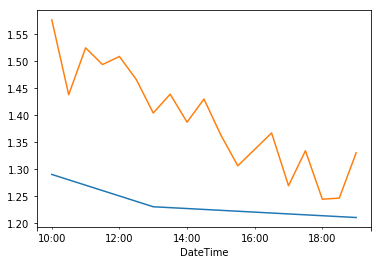

In [65]:
fore_sel.htsgwsfc.plot()
wb_data.Hsig.plot()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [66]:
mean_squared_error(wb_data.Hsig, fore_sel.htsgwsfc)

ValueError: Found input variables with inconsistent numbers of samples: [18, 19]

In [67]:
wb_data.Hsig.cov(fore_sel.htsgwsfc)

0.002020197167116052

In [ ]:
def generate_report():
    """Takes the wb and forecast data and generates a html report based on the plots"""

    plots = []
    site_data = get_data()
    for d in site_data:
        plots.append(plot_bokeh(d))
        plots.append(plot_bokeh_per(d))
    
    name = 'NOAA_Forecast_Report_online.html'
    html = open(name, 'w')
    
    begin = """<!DOCTYPE html>\n
                <html lang="en">\n
                <head>\n
                  <title>Wave Information</title>\n
                  <meta charset="utf-8">\n
              <meta name="viewport" content="width=device-width, initial-scale=1">\n
              <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">\n
              <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>\n
              <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/js/bootstrap.min.js"></script>\n
            </head>\n
            <body>\n
                <div class="container">\n
                  <h1>Forecast and Actual Wave Information</h1>\n
                  <p>Data sourced from &copy; Queensland Government and &copy; National Oceanographic and Atmospheric Administration 2019</p> \n
                  <p>A comparison of forecast data from the NOAA's multigrid wave model and wave monitoring stations from Queensland Government</p> \n
                </div>\n
                <div class="container">\n
                  <h3>Plot Explanation:</h3>\n
                    <p>The plots contain the measured wave height (green) recent forecast (solid blue) and the previous 3 forecasts (light blue)</p>\n
                    <p>The measured wave height uses the significant wave height estimated as Hsig (the highest 1/3 waves), the forecast is calculated as Hm0 (from the wave spectra)</p>\n
                </div>\n
            </body>\n"""
    html.write(begin)
    bokeh_setup = """<link
    href="https://cdn.pydata.org/bokeh/release/bokeh-1.0.1.min.css"
    rel="stylesheet" type="text/css">
    <link
    href="https://cdn.pydata.org/bokeh/release/bokeh-widgets-1.0.1.min.css"
    rel="stylesheet" type="text/css">
    <link
    href="https://cdn.pydata.org/bokeh/release/bokeh-tables-1.0.1.min.css"
    rel="stylesheet" type="text/css">

    <script src="https://cdn.pydata.org/bokeh/release/bokeh-1.0.1.min.js"></script>
    <script src="https://cdn.pydata.org/bokeh/release/bokeh-widgets-1.0.1.min.js"></script>"""
    html.write(bokeh_setup)
    size = """<style type="text/css">
    .plots {
        height: 35%;
        width: 75%;
        margin: auto;
    }</style>"""
    
    
    
    for figs in plots:
        html.write("<head>\n")
        html.write(size + "\n")
        html.write(figs[0] + "\n")
        html.write("</head>")
        html.write("<body>\n")
        html.write(""""<div class="plots">""")
        html.write(figs[-1])
        html.write("</div>")
        html.write("</body>")
        
    html.close()
    return

In [ ]:
if __name__ == '__main__':
    generate_report()